In [672]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from collections import defaultdict
from scipy.stats import kstest, norm, uniform, beta, expon, truncnorm

from scipy.optimize import brentq

from tqdm import tqdm

import sdv
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.single_table import GaussianCopulaSynthesizer
tqdm.pandas()

import warnings
warnings.filterwarnings(action='ignore')

In [667]:
data = pd.read_csv('American_Income.csv')

In [668]:
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [18]:
def check_missing(data):
    missing_value = [col for col in data.columns if data[col].isnull().sum()>0]
    if len(missing_value)== 0:
        return "No missing value"
    else:
        return "Missing values are find at " + str(missing_value)


def typeInDict(data):
    dtype_dict = data.dtypes.to_dict()
    organized_dict = defaultdict(list)

    for column, dtype in dtype_dict.items():
        organized_dict[str(dtype)].append(column)

    # Convert defaultdict to a regular dictionary
    organized_dict = dict(organized_dict)
    
    return organized_dict


def data_by_type(organized_dict,data):
    
    type_dict = {}
    for types in list(organized_dict.keys()):
        type_dict [types]= {}
        for column_name in organized_dict[types]:
            type_dict[types][column_name] = np.array(data[column_name])
    
    return type_dict


In [669]:
check_missing(data)

'No missing value'

In [670]:
organized_dict =typeInDict(data)

organized_dict

{'int64': ['age',
  ' fnlwgt',
  ' education-num',
  ' capital-gain',
  ' capital-loss',
  ' hours-per-week'],
 'object': [' workclass',
  ' education',
  ' marital-status',
  ' occupation',
  ' relationship',
  ' race',
  ' sex',
  ' native-country',
  ' salary']}

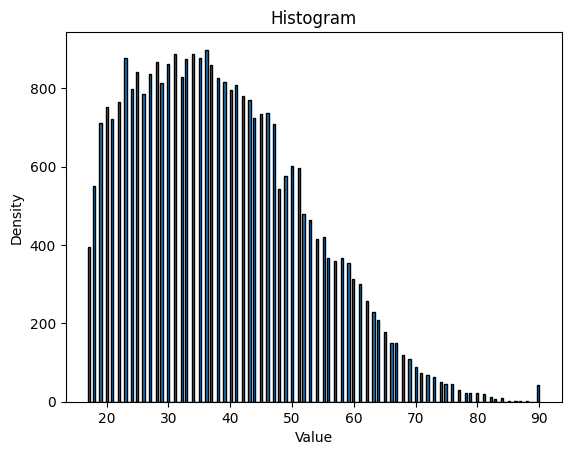

In [671]:
plt.hist(data['age'], bins = 200,edgecolor = 'black')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram')
plt.show()

In [42]:
def best_fit_distribution(column_data):
    # Define the distributions to test
    distributions = ['norm', 'uniform', 'beta', 'expon', 'truncnorm']
    best_fit = None
    best_p_value = -1

    # Test each distribution
    for distribution in distributions:
        if distribution == 'norm':
            params = norm.fit(column_data)
            D, p_value = kstest(column_data, distribution, args=params)
        elif distribution == 'uniform':
            params = uniform.fit(column_data)
            D, p_value = kstest(column_data, distribution, args=params)
        elif distribution == 'beta':
            # Beta distribution requires data to be in (0, 1) range
            epsilon = 1e-10
            scaled_data = (column_data - column_data.min() + epsilon) / (column_data.max() - column_data.min() + 2 * epsilon)
            params = beta.fit(scaled_data, floc=0, fscale=1)
            D, p_value = kstest(scaled_data, distribution, args=params)
        elif distribution == 'expon':
            params = expon.fit(column_data)
            D, p_value = kstest(column_data, distribution, args=params)
        elif distribution == 'truncnorm':
            mean,std_dev = norm.fit(column_data)
            lower_bound = (column_data.min() - mean)/std_dev
            upper_bound = (column_data.max() - mean)/ std_dev
            params = truncnorm.fit(column_data, lower_bound, upper_bound)
            D,p_value = kstest(column_data,distribution, args= params)

        if p_value > best_p_value:
            best_p_value = p_value
            best_fit = distribution
            best_params = params

    return best_fit, best_p_value,best_params

# # Sample data
# data1 = pd.DataFrame({
#     'A': np.random.normal(0, 1, 1000),
#     'B': np.random.uniform(0, 1, 1000),
#     'C': np.random.beta(2, 5, 1000),
#     'D': np.random.exponential(1, 1000)
# })

# # Determine the best fit distribution for each column
# results = {}
# for column in data1.columns:
#     best_fit, p_value = best_fit_distribution(data1[column])
#     results[column] = (best_fit, p_value)

# print(results)

In [674]:
type_dict = data_by_type(organized_dict,data)

In [675]:
data_sta_model = type_dict["int64"]

In [676]:
data_sta_model.keys()

dict_keys(['age', ' fnlwgt', ' education-num', ' capital-gain', ' capital-loss', ' hours-per-week'])

In [678]:
results = {}
for column in list(data_sta_model.keys()):
    best_fit, p_value, best_params = best_fit_distribution(data[column])
    results[column] = (best_fit, p_value)

print(results)

{'age': ('norm', 5.1419665705512075e-113), ' fnlwgt': ('beta', 5.761282883958129e-91), ' education-num': ('norm', 0.0), ' capital-gain': ('norm', 0.0), ' capital-loss': ('norm', 0.0), ' hours-per-week': ('norm', 0.0)}


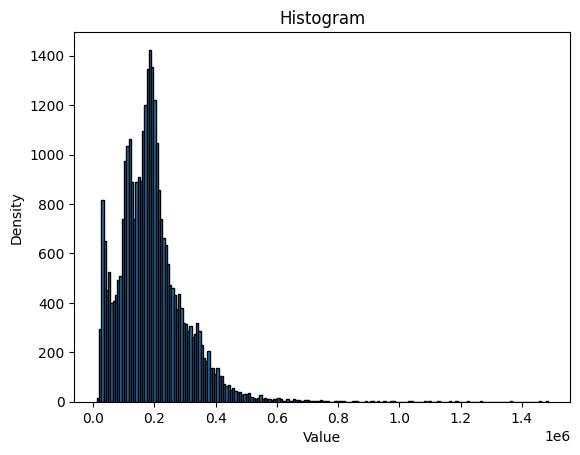

In [679]:
plt.hist(data[' fnlwgt'], bins = 200,edgecolor = 'black')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram')
plt.show()

#### Why using Gaussian Mixture Model?
The Gaussian Mixture Model (GMM) is indeed a popular and powerful method for modeling the distribution of data, and it can be particularly effective for generating synthetic data that resembles a given real dataset. Here are some reasons why GMMs are often used for this purpose:

- Flexibility: GMMs are very flexible because they can model a wide range of data distributions. By combining multiple Gaussian distributions, they can approximate any continuous distribution to a reasonable degree of accuracy.

- Capturing Subpopulations: If data contains several subpopulations (clusters), GMMs can capture these through its components. Each Gaussian in the mixture can represent a different cluster.

- Parameter Estimation: GMMs come with well-established algorithms for parameter estimation, such as the Expectation-Maximization (EM) algorithm, which iteratively estimates the parameters of the Gaussians that make up the model.

- Uncertainty Modeling: GMMs not only capture the central tendency (mean) of the data but also its variability (covariance), which is essential when trying to generate realistic synthetic data.

- Soft Clustering: GMMs provide probabilities of belonging to clusters rather than hard assignments, which can be a more nuanced way of representing the underlying structure in data.

### Try Using Gaussian Mixture Model To Capture The Distribution

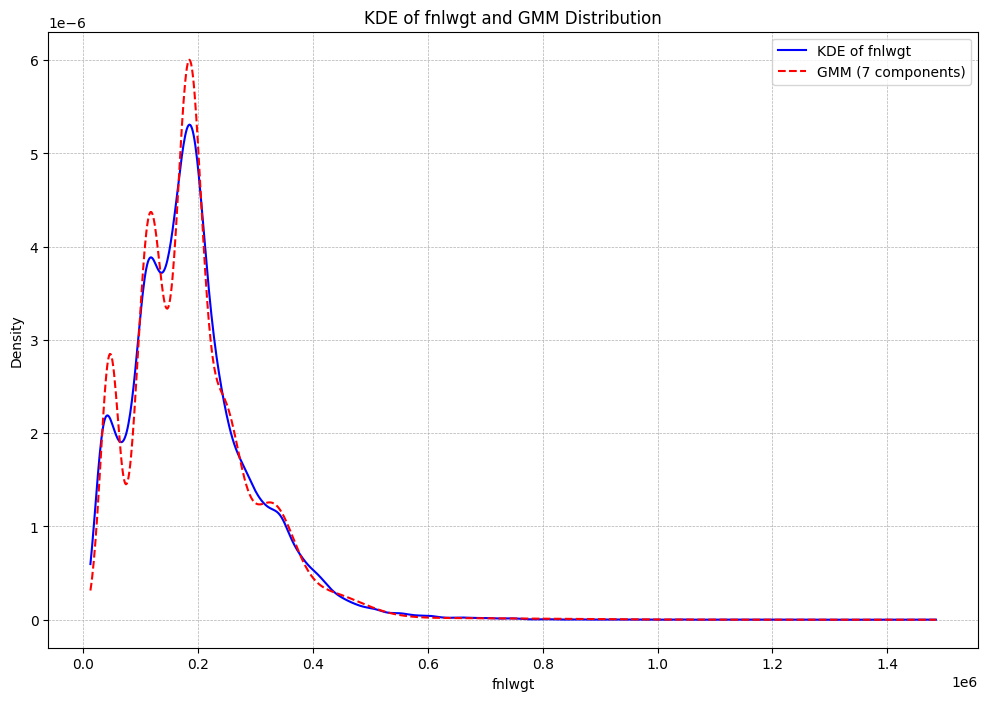

In [59]:
from sklearn.mixture import GaussianMixture
import scipy.stats as stats


data_fnlwgt = data[' fnlwgt']

# Determine the optimal number of components for GMM using BIC
bic = []
n_components_range = range(1, 11)
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(data_fnlwgt.values.reshape(-1, 1))
    bic.append(gmm.bic(data_fnlwgt.values.reshape(-1, 1)))

optimal_components = n_components_range[np.argmin(bic)]

# Fit the GMM with the optimal number of components
gmm = GaussianMixture(n_components=optimal_components)
gmm.fit(data_fnlwgt.values.reshape(-1, 1))

# Generate the combined GMM distribution
x = np.linspace(min(data_fnlwgt), max(data_fnlwgt), 1000)
gmm_pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))

# KDE for comparison
kde = stats.gaussian_kde(data_fnlwgt)

# Plot
plt.figure(figsize=(12, 8))
plt.plot(x, kde(x), label='KDE of fnlwgt', color='blue')
plt.plot(x, gmm_pdf, label=f'GMM ({optimal_components} components)', color='red', linestyle='--')
plt.title('KDE of fnlwgt and GMM Distribution')
plt.xlabel('fnlwgt')
plt.ylabel('Density')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


In [65]:
def findBestComp(data):
    bic = []
    n_components_range = range(1, 11)
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(data.values.reshape(-1, 1))
        bic.append(gmm.bic(data.values.reshape(-1, 1)))

    optimal_components = n_components_range[np.argmin(bic)]

    return optimal_components

In [60]:
print(optimal_components)

7



---

### Given a Gaussian Mixture Model (GMM) with \( k \) Gaussian components, the CDF for a GMM at a value \( x \) is:

\[
$\text{CDF}_{\text{GMM}}(x) = \sum_{i=1}^{k} \pi_i \cdot \text{CDF}_{\text{Gaussian}_i}(x)$
\]

Where:
- \( k \) is the number of Gaussian components in the GMM.
- \( $\pi_i$\) is the weight of the \($i$\)-th Gaussian component.
- \( $\text{CDF}_{\text{Gaussian}_i}(x) $\) is the CDF of the \( $i$ \)-th Gaussian component evaluated at \( x \), which is given by:

\[
$\text{CDF}_{\text{Gaussian}_i}(x) = \frac{1}{2} \left[ 1 + \text{erf} \left( \frac{x - \mu_i}{\sigma_i \sqrt{2}} \right) \right]$
\]

Where:
- \( $\mu_i $\) is the mean of the \( i \)-th Gaussian component.
- \( $\sigma_i $\) is the standard deviation of the \( i \)-th Gaussian component.
- \( $\text{erf}$ \) is the error function.

---



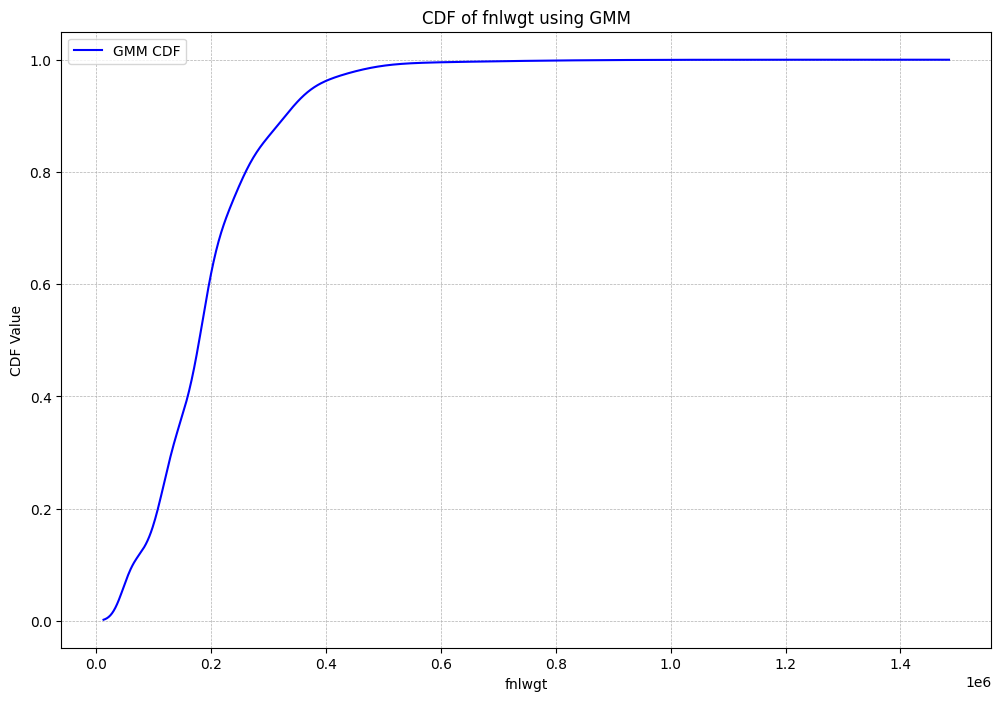

In [74]:
def gmm_cdf(x, gmm):
    """
    Compute the CDF of the GMM at point x.
    
    Parameters:
    - x: Point at which to evaluate the CDF
    - gmm: Fitted GaussianMixture object
    
    Returns:
    - CDF value at point x
    """
    cdf_value = 0
    for weight, mean, covariance in zip(gmm.weights_, gmm.means_, gmm.covariances_):
        cdf_value += weight * stats.norm.cdf(x, mean, np.sqrt(covariance)) 
    return cdf_value[0][0]

# Compute the CDF values for the 'fnlwgt' column
# Compute and plot the CDF for the 'fnlwgt' column using the GMM
x_values = np.linspace(min(data_fnlwgt), max(data_fnlwgt), 1000)


cdf_values = [gmm_cdf(x_val, gmm) for x_val in x_values]

#cdf_values = [gmm_cdf(gmm, x_val)[0][0] for x_val in x_values]  # Correcting the shape

plt.figure(figsize=(12, 8))
plt.plot(x_values, cdf_values, label='GMM CDF', color='blue')
plt.title('CDF of fnlwgt using GMM')
plt.xlabel('fnlwgt')
plt.ylabel('CDF Value')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()



In [ ]:
def gmm_inverse_cdf(gmm, p, lower_bound, upper_bound):
    # Define the function for which we want to find the root
    func = lambda x: gmm_cdf(x, gmm) - p
    # Use Brent's method to find the root (inverse CDF value)
    x_value = brentq(func, lower_bound, upper_bound)
    return x_value

## Understanding the Cumulative Distribution Function (CDF)

The CDF provides insights into the distribution and properties of data. Here's what the CDF can tell us:

### 1. **Shape and Distribution**:
- The CDF is a **monotonically increasing function**, starting from 0 and ending at 1. 
- The **steepness or flatness** of the curve at different sections offers insights:
  - **Steeper sections** correspond to areas of higher data density.
  - **Flatter sections** indicate sparser regions.

### 2. **Median and Quantiles**:
- The **median (50th percentile)** of the data can be located where the CDF value is 0.5. 
- Other quantiles (e.g., 25th, 75th) can be read directly from the CDF.
- Quantiles help in understanding the distribution's spread and variability.

### 3. **Tail Behavior**:
- Behavior near 0 and 1 reveals insights into the tails:
  - A slower increase near 0 indicates a **lighter left tail**.
  - A slower approach to 1 indicates a **lighter right tail**.
  - A rapid increase near 0 or approach to 1 indicates **heavier tails**.

### 4. **Comparison with Other Distributions**:
- Overlaying another CDF allows for visual comparison.
- Useful to determine how closely data follows a theoretical or target distribution.

### 5. **Identifying Multi-modality**:
- The CDF doesn't directly show modes (peaks).
- **Inflection points or changes in steepness** hint at multiple modes.
- Especially true if data is modeled using mixture models like GMM.

### Insights from the 'fnlwgt' Column CDF:
- Steepness in the leftmost section suggests a significant portion of data in that range.
- A change in slope around the mid-range hints at the multi-modal nature.(multiple peak(frequency))
- Gradual approach to 1 suggests the right tail isn't very heavy.

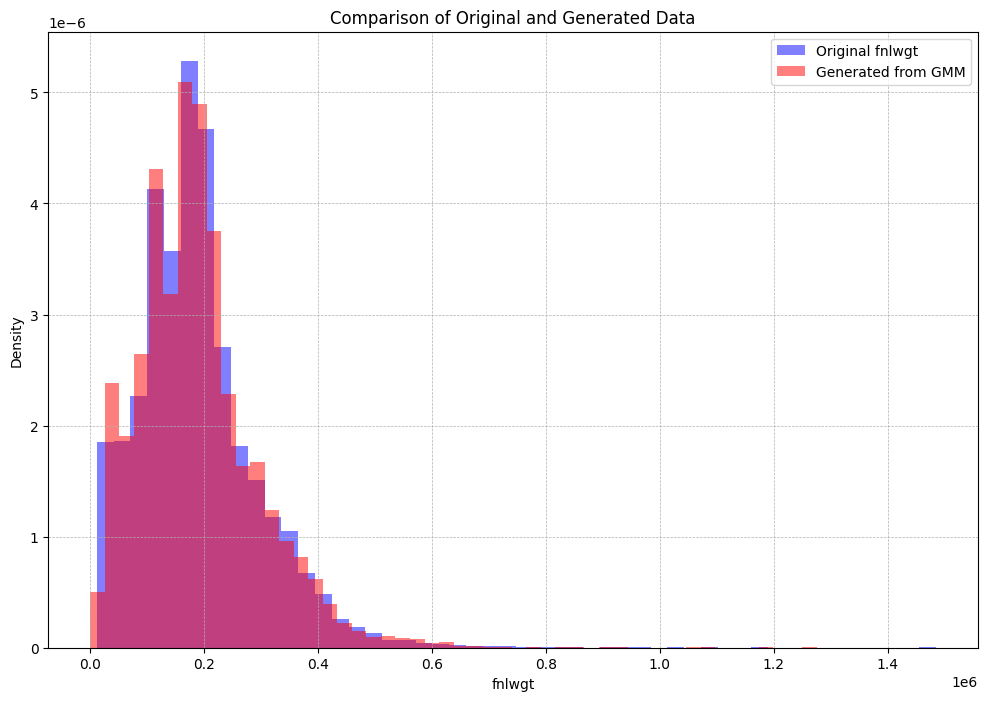

In [30]:
def sample_from_gmm(gmm, num_samples):
    """
    Generate samples from a GMM.
    
    Parameters:
    - gmm: A fitted GaussianMixture object.
    - num_samples: Number of samples to generate.
    
    Returns:
    - samples: Array of generated samples.
    """
    # Step 1: Randomly select component based on weights
    chosen_components = np.random.choice(len(gmm.weights_), size=num_samples, p=gmm.weights_)
    
    # Step 2: Generate samples for each chosen component
    samples = []
    for component in chosen_components:
        sample = np.random.normal(gmm.means_[component], np.sqrt(gmm.covariances_[component]))
        samples.append(sample[0])
    
    return np.array(samples)

# Generate random samples from the GMM
num_samples = 10000
generated_samples = sample_from_gmm(gmm, num_samples)

# Plot the histogram of generated samples alongside the original 'fnlwgt' distribution
plt.figure(figsize=(12, 8))
plt.hist(data_fnlwgt, bins=50, density=True, color='blue', alpha=0.5, label='Original fnlwgt')
plt.hist(generated_samples, bins=50, density=True, color='red', alpha=0.5, label='Generated from GMM')
plt.title('Comparison of Original and Generated Data')
plt.xlabel('fnlwgt')
plt.ylabel('Density')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

# Function to compute the CDF of the GMM at a given value x
def gmm_cdf(gmm, x):
    cdf_value = 0
    for weight, mean, covariance in zip(gmm.weights_, gmm.means_, gmm.covariances_):
        cdf_value += weight * norm.cdf(x, mean, np.sqrt(covariance))
    return cdf_value

# Fit GMM to column data and compute CDF values
def fit_gmm_and_compute_cdf(column_data, n_components):
    gmm = GaussianMixture(n_components=n_components).fit(column_data.reshape(-1, 1))
    cdf_values = np.array([gmm_cdf(gmm, x) for x in column_data])
    return cdf_values

# Apply the inverse CDF of the standard Gaussian distribution
def gaussian_inverse_cdf(p_values):
    return norm.ppf(p_values)

# Gaussian Copula Transformation
def apply_gaussian_copula_to_column(column_data, n_components):
    # Step 1: Fit GMM and compute CDF values
    cdf_values = fit_gmm_and_compute_cdf(column_data, n_components)
    
    # Step 2: Convert CDF values using Gaussian Copula
    transformed_data = gaussian_inverse_cdf(cdf_values)
    
    return transformed_data


## Select AGE and HOURS-PER-WEEK for generate new data

In [33]:
age_hours_df = data[['age', ' hours-per-week']]

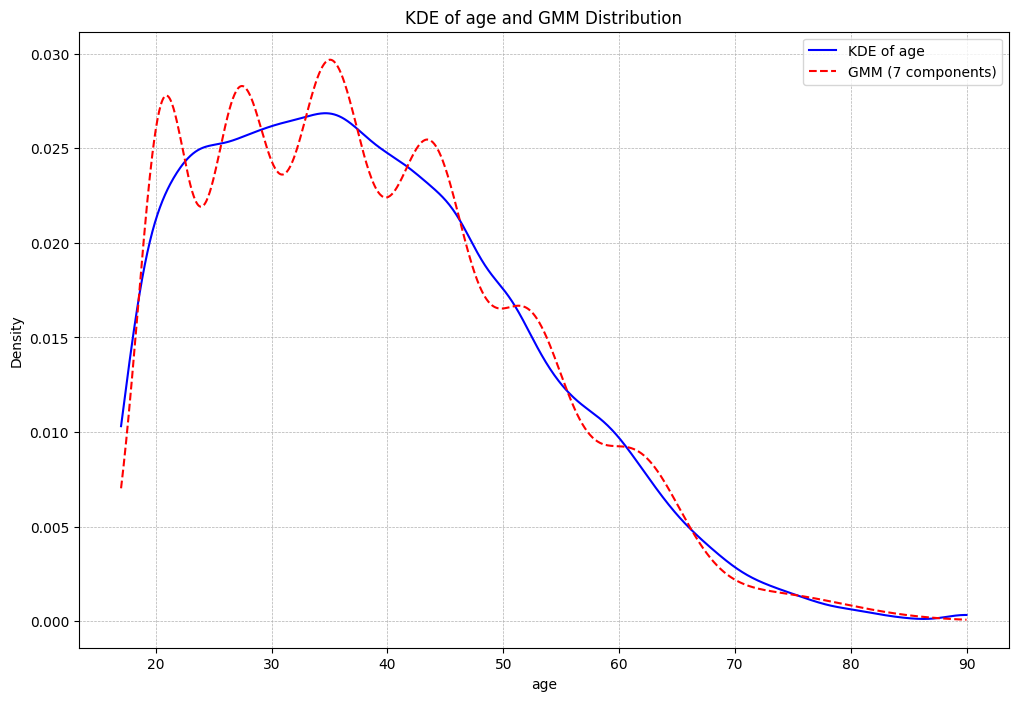

In [52]:
data_age = age_hours_df['age']

# Determine the optimal number of components for GMM using BIC again
bic = []
n_components_range = range(1, 11)
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(data_age.values.reshape(-1, 1))
    bic.append(gmm.bic(data_age.values.reshape(-1, 1)))

optimal_components = n_components_range[np.argmin(bic)]

# Fit the GMM with the optimal number of components
gmm = GaussianMixture(n_components=optimal_components)
gmm.fit(data_age.values.reshape(-1, 1))

# Generate the combined GMM distribution
x = np.linspace(min(data_age), max(data_age), 1000)
gmm_pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))

# KDE for comparison
kde = stats.gaussian_kde(data_age)

# Plot
plt.figure(figsize=(12, 8))
plt.plot(x, kde(x), label='KDE of age', color='blue')
plt.plot(x, gmm_pdf, label=f'GMM ({optimal_components} components)', color='red', linestyle='--')
plt.title('KDE of age and GMM Distribution')
plt.xlabel('age')
plt.ylabel('Density')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

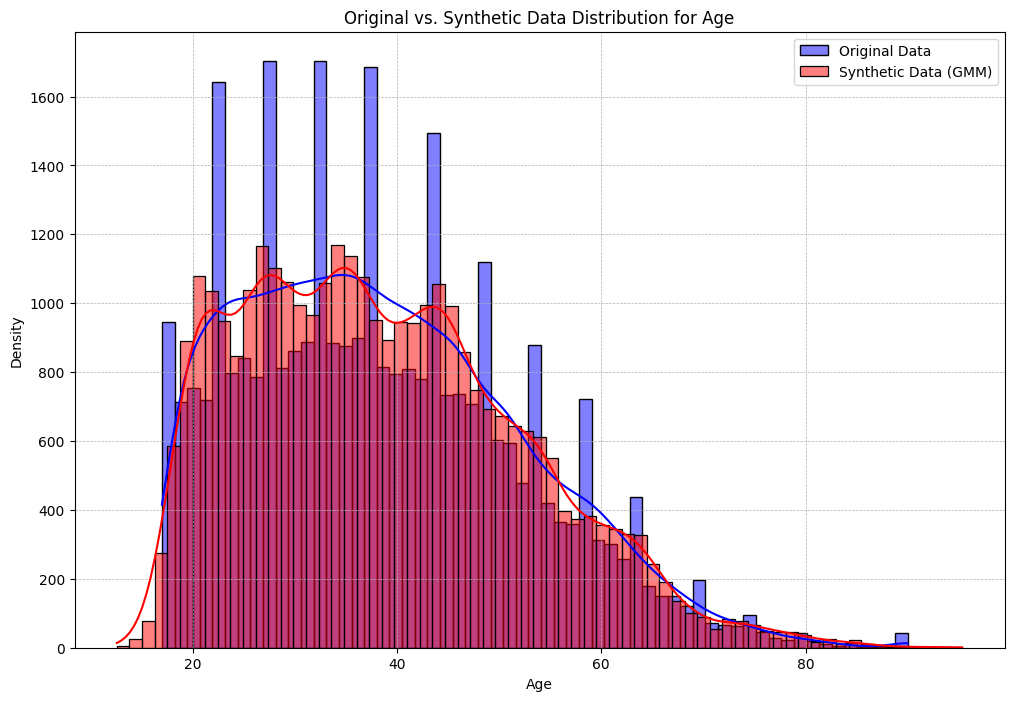

In [53]:
# Generate synthetic data samples from the GMM
synthetic_data_age = gmm.sample(len(data_age))[0].flatten()

# Plotting
plt.figure(figsize=(12, 8))

# Plot original data
sns.histplot(data_age, kde=True, color='blue', label='Original Data', alpha=0.5)

# Plot synthetic data
sns.histplot(synthetic_data_age, kde=True, color='red', label='Synthetic Data (GMM)', alpha=0.5)

plt.title('Original vs. Synthetic Data Distribution for Age')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### Steps Explained:
1. `transformed_data_age = np.sqrt(data_age) `: make skewed data becomes more "bell-shaped" and "Gaussian-Like"
2. `optimal_components = n_components_range[np.argmin(bic)] `: find the best number of components
3. `gmm.fit(transformed_data_age.values.reshape(-1, 1)) ` : fit the dataset
4. `synthetic_data_age_transformed = gmm.sample(len(data_age))[0].flatten() ` : Generate
5. `synthetic_data_age = synthetic_data_age_transformed**2 ` : Inverse transform
6. Resampling: Purely synthetic data might miss some nuances of the original data. We mix in some of the original data and combine these samples with the GMM-generated data. This hybrid approach aims to capture the best of both worlds.
7. Visualization and compute all the evaluation metrics



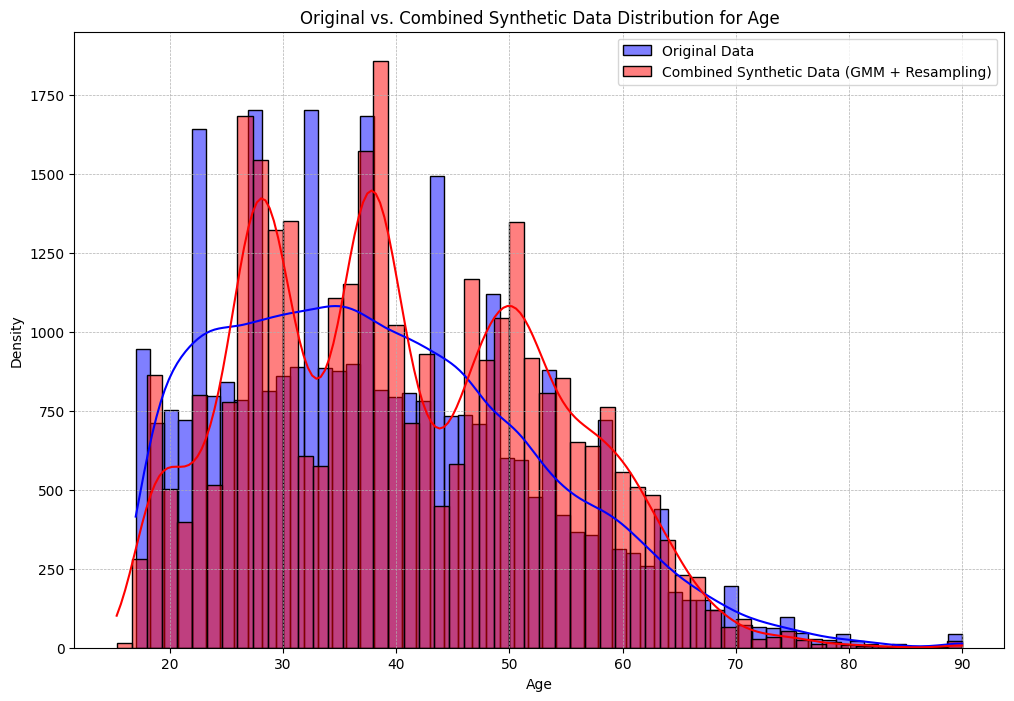

In [50]:
# 1. Data Transformation: Apply square root transformation
transformed_data_age = np.sqrt(data_age) 

# 2. Determine the optimal number of components for GMM using BIC
bic = []
n_components_range = range(1, 11)
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(transformed_data_age.values.reshape(-1, 1))
    bic.append(gmm.bic(transformed_data_age.values.reshape(-1, 1)))

optimal_components = n_components_range[np.argmin(bic)]

# Fit the GMM with the optimal number of components
gmm = GaussianMixture(n_components=optimal_components)
gmm.fit(transformed_data_age.values.reshape(-1, 1))

# Generate synthetic data samples from the GMM (in the transformed space)
synthetic_data_age_transformed = gmm.sample(len(data_age))[0].flatten()

# Convert the synthetic data back to the original space
synthetic_data_age = synthetic_data_age_transformed**2

# 3. Resampling: Mix original and GMM-generated data
resample_indices = np.random.choice(data_age.index, size=int(0.5 * len(data_age)), replace=True)
resampled_data_age = data_age[resample_indices]
combined_synthetic_data_age = np.concatenate([resampled_data_age, synthetic_data_age[:int(0.5 * len(data_age))]])

# Plotting
plt.figure(figsize=(12, 8))

# Plot original data
sns.histplot(data_age, kde=True, color='blue', label='Original Data', alpha=0.5)

# Plot synthetic data
sns.histplot(combined_synthetic_data_age, kde=True, color='red', label='Combined Synthetic Data (GMM + Resampling)', alpha=0.5)

plt.title('Original vs. Combined Synthetic Data Distribution for Age')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


## Metrics Explainations:
1. Mean: Average of the data, tells the center value
2. Median: Another way to see the center, but not affected by the super high and super low value
3. Standard Deviation: Measure how spread the data, tells if the numer close to mean or spread out over the range
4. Range: The difference between the highest value and lowest value
5. IQR:  The difference between the value at the 75% mark and the value at the 25% mark when line up all the numbers.Shows how spread out the "middle half" of your data is. It's another way to see spread but without the influence of potential outliers.
6. Skewness: Measure of how lopesided data is, tells if the data is lean more to the right or left, close to 0 means it's pretty balanced
7. Kurtosis： Measure how pointy or flat the top of  the data. Gives insight into tails and peak of distribution, high value means alot of outlier low means fewer outlier and flatter peak
    - Mesokurtic (Kurtosis≈0): The bell curve or normal distribution is mesokurtic
    - Leptokurtic (Kurtosis > 0) : It's more prone to produce outliers than a normal distribution
    - Platykurtic (Kurtosis < 0) : It produces fewer and less extreme outliers than the normal distribution

In [56]:
def compute_descriptive_stats(data):
    """Compute descriptive statistics for a given dataset."""
    # Convert to a Pandas Series if input is a numpy array
    if isinstance(data, np.ndarray):
        data = pd.Series(data)
    
    stats = {
        'Mean': data.mean(),
        'Median': data.median(),
        'Standard Deviation': data.std(),
        'Range': data.max() - data.min(),
        'IQR': data.quantile(0.75) - data.quantile(0.25),
        'Skewness': data.skew(),
        'Kurtosis': data.kurtosis()
    }
    
    return pd.Series(stats)


original_stats = compute_descriptive_stats(data_age)
synthetic_stats = compute_descriptive_stats(synthetic_data_age)

# Display the stats side-by-side for comparison
comparison_df = pd.DataFrame({'Original Data': original_stats, 'Synthetic Data (GMM + resampling)': synthetic_stats})

comparison_df


,Original Data,Synthetic Data (GMM + resampling)
Mean,38.581647,38.618286
Median,37.000000,36.967157
Standard Deviation,13.640433,13.648276
Range,73.000000,82.753760
IQR,20.000000,20.011087
Skewness,0.558743,0.559743
Kurtosis,-0.166127,-0.164404


In [57]:
original_stats = compute_descriptive_stats(data_age)
synthetic_stats = compute_descriptive_stats(reconstruct_data)

# Display the stats side-by-side for comparison
comparison_df = pd.DataFrame({'Original Data': original_stats, 'Synthetic Data (GMM)': synthetic_stats})

comparison_df

,Original Data,Synthetic Data (GMM)
Mean,38.581647,38.799331
Median,37.000000,38.787184
Standard Deviation,13.640433,13.723335
Range,73.000000,115.999778
IQR,20.000000,18.303168
Skewness,0.558743,0.005739
Kurtosis,-0.166127,0.063517


norm 5.1419665705512075e-113 (38.58164675532078, 13.640223092304275)


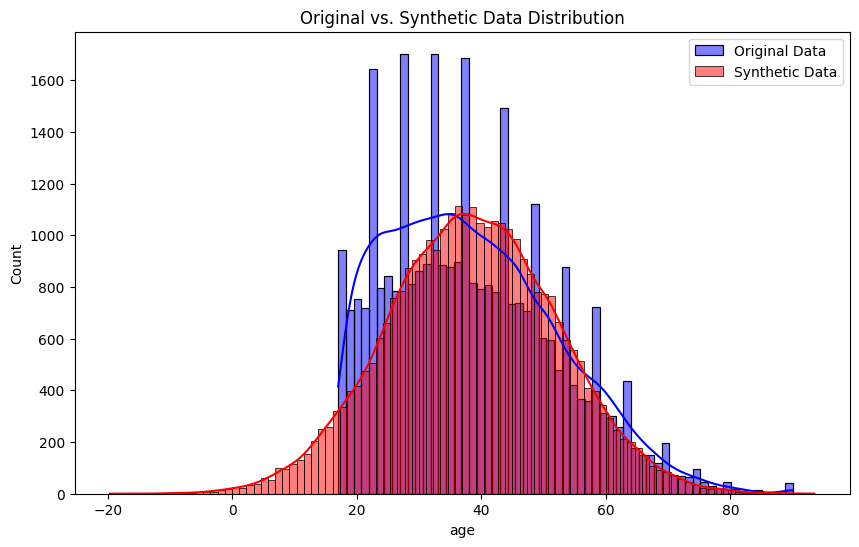

In [680]:
best_fit, best_p_value, best_params = best_fit_distribution(data_age)    ##by using the method that mentioned in the sdv paper

print(best_fit, best_p_value, best_params)
reconstruct_data = norm.rvs(*best_params, size=len(data_age))

import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(data_age, kde=True, color='blue', label='Original Data', alpha=0.5)
sns.histplot(reconstruct_data, kde=True, color='red', label='Synthetic Data', alpha=0.5)
plt.legend()
plt.title("Original vs. Synthetic Data Distribution")
plt.show()

## Try to generate synthetic data by using GMM

In [513]:
age_hours_df = data[['age', ' hours-per-week']] 

GMM_cdf_table = pd.DataFrame()  #initial dataframe to store all the cdf value

In [521]:
age_components = findBestComp(age_hours_df['age'])

hour_components = findBestComp(age_hours_df[' hours-per-week'])

print(age_components)
print(hour_components)

10
8


In [558]:
#inital the gmm to fit
age_components = findBestComp(age_hours_df['age'])

gmm_age = GaussianMixture(n_components=10)
gmm_age.fit(age_hours_df['age'].values.reshape(-1, 1))

# Fit a GMM to the 'hours-per-week' column
gmm_hours = GaussianMixture(n_components=9)  
gmm_hours.fit(age_hours_df[' hours-per-week'].values.reshape(-1, 1))

GaussianMixture(n_components=9)

In [559]:
# store all the cdf into the initialized cdf dataframe

GMM_cdf_table['age'] = age_hours_df['age'].apply(lambda x: gmm_cdf(x, gmm_age))
GMM_cdf_table[' hours-per-week'] = age_hours_df[' hours-per-week'].apply(lambda x: gmm_cdf(x, gmm_hours))

In [560]:
GMM_cdf_table.to_csv('GMM_cdf_table.csv')

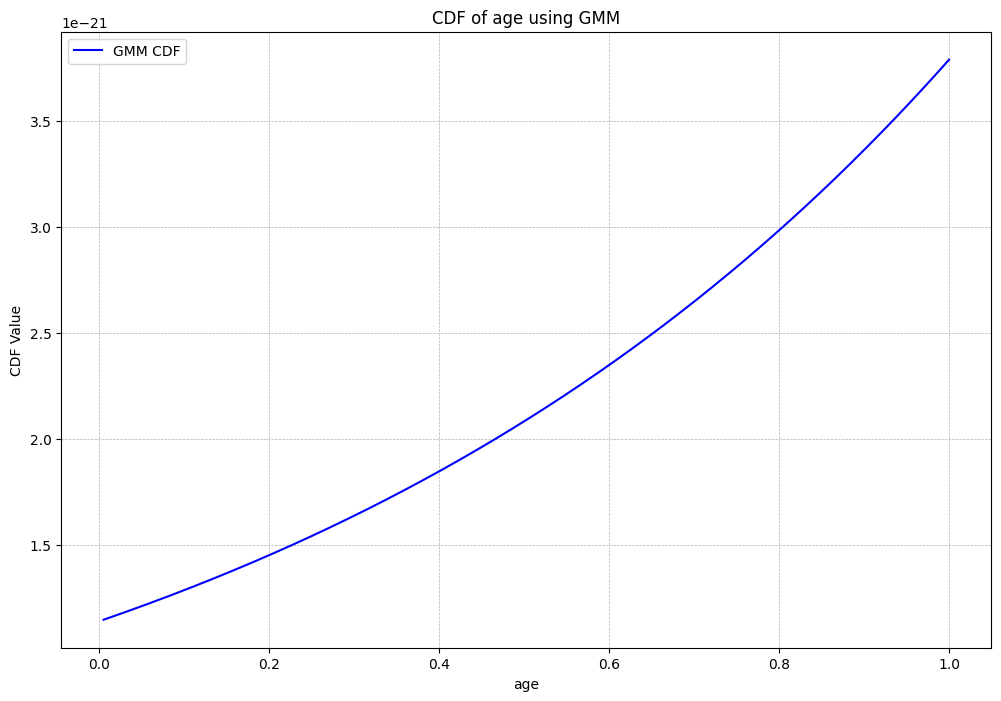

In [561]:
x_values = np.linspace(min(GMM_cdf_table['age']), max(GMM_cdf_table['age']), 1000)


cdf_values = [gmm_cdf(x_val, gmm_age) for x_val in x_values]

#cdf_values = [gmm_cdf(gmm, x_val)[0][0] for x_val in x_values]  # Correcting the shape

plt.figure(figsize=(12, 8))
plt.plot(x_values, cdf_values, label='GMM CDF', color='blue')
plt.title('CDF of age using GMM')
plt.xlabel('age')
plt.ylabel('CDF Value')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

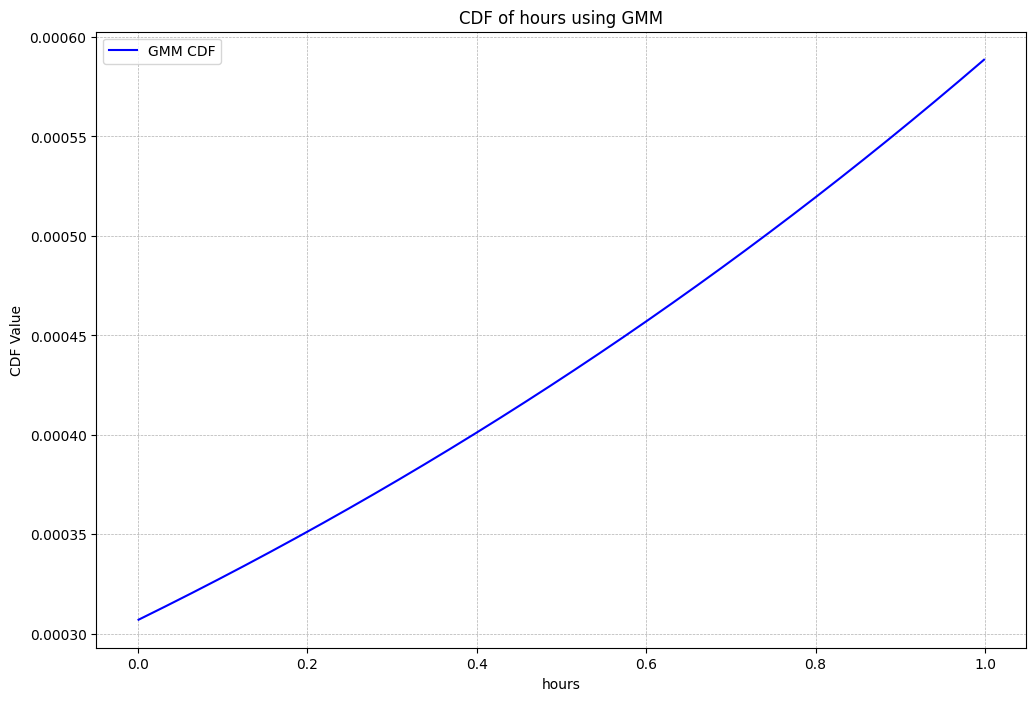

In [562]:
x_values = np.linspace(min(GMM_cdf_table[' hours-per-week']), max(GMM_cdf_table[' hours-per-week']), 1000)


cdf_values = [gmm_cdf(x_val, gmm_hours) for x_val in x_values]

#cdf_values = [gmm_cdf(gmm, x_val)[0][0] for x_val in x_values]  # Correcting the shape

plt.figure(figsize=(12, 8))
plt.plot(x_values, cdf_values, label='GMM CDF', color='blue')
plt.title('CDF of hours using GMM')
plt.xlabel('hours')
plt.ylabel('CDF Value')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [563]:
print(GMM_cdf_table['age'].max(), GMM_cdf_table[' hours-per-week'].max())

0.9998394551430748 0.9988745678195818


In [564]:
def get_row_vector(df): 
    row_vectors_list = [row.values for _, row in df.iterrows()]

    return row_vectors_list

 

In [565]:
cdf_age_hour_row_vectors_list = get_row_vector(GMM_cdf_table)
print(cdf_age_hour_row_vectors_list[1])

[0.79467705 0.02837864]


In [566]:
from scipy.optimize import brentq

age_upper_bound = age_hours_df['age'].max()
age_lower_bound = age_hours_df['age'].min()

hours_upper_bound = age_hours_df[' hours-per-week'].max()
hours_lower_bound = age_hours_df[' hours-per-week'].min()

def gmm_inverse_cdf(p_values):
    """
    Compute the inverse CDF (quantile function) of the GMM for a given probability p.
    
    Parameters:
    - p: Probability for which to compute the inverse CDF
    
    Returns:
    - x value such that gmm_cdf(x, gmm) = p
    """
    return norm.ppf(p_values)



In [567]:
GMM_invers_cdf_table = pd.DataFrame()

### why convet to standard normal distribution?
- Remove Distribution Shape Bias: Different columns may have different distribution shapes, and these shapes can influence the estimation of covariances. By converting to standard normal, the SDV removes any bias that might be induced by the shape of the original distributions.

- Uniformity in Scale: Standard normal distribution has a mean of 0 and a standard deviation of 1. This uniformity in scale allows for a consistent comparison and computation across different columns, which may originally have different scales and units.

- Facilitate the Use of Gaussian Copula: The Gaussian Copula requires inputs to be in the form of a standard normal distribution. It uses the inverse cumulative distribution function (CDF) of the Gaussian to transform the original data. This step is crucial for the copula to capture the dependence structure between the variables correctly.

- Simplification of the Model: By transforming all columns to a standard normal distribution, the SDV simplifies the generative model. This simplification makes it easier to synthesize new data that maintains the statistical relationships of the original data.

- Covariance Matrix Computation: After the transformation, the covariance matrix of the transformed values can be computed. This matrix, along with the parameters for each column distribution, becomes the generative model for the table. It contains all the information from the original table in a compact form and is used to synthesize new data.

In [568]:
# converting all column distributions to standard normal before finding the covariances.
GMM_invers_cdf_table['age'] = GMM_cdf_table['age'].progress_apply(lambda x: gmm_inverse_cdf(x))  #
GMM_invers_cdf_table[' hours-per-week'] = GMM_cdf_table[' hours-per-week'].progress_apply(lambda x: gmm_inverse_cdf(x))




















100%|██████████| 32561/32561 [00:02<00:00, 15914.34it/s]A






























































































































































































































































































































































































































100%|██████████| 32561/32561 [00:02<00:00, 14309.25it/s]


In [569]:
GMM_invers_cdf_table.to_csv("GMM_invers_cdf_table.csv")

In [570]:
print(GMM_invers_cdf_table['age'].max(),GMM_invers_cdf_table['age'].min(), GMM_invers_cdf_table[' hours-per-week'].max(),  GMM_invers_cdf_table[' hours-per-week'].min())

3.5976626420810627 -2.5316315695443388 3.054965468825385 -3.2441558203859473


In [571]:
GMM_invers_cdf_table

,age,hours-per-week
0,0.126680,-0.067841
1,0.822758,-1.905175
2,0.058275,-0.067841
3,0.995459,-0.067841
4,-0.650281,-0.067841
...,...,...
32556,-0.728612,-0.755189
32557,0.193862,-0.067841
32558,1.299348,-0.067841
32559,-1.237445,-1.471799


In [572]:
age_hours_df

,age,hours-per-week
0,39,40
1,50,13
2,38,40
3,53,40
4,28,40
...,...,...
32556,27,38
32557,40,40
32558,58,40
32559,22,20


In [573]:
covariance_matrix = GMM_invers_cdf_table.cov()

covariance_matrix.to_csv("covariance_matrix.csv")

In [601]:
# Check the CDF values at the bounds for the given probabilities
gmm_age_dict = {
    'weights_': gmm_age.weights_, 
    'means_': gmm_age.means_, 
    'covariances_': gmm_age.covariances_ 
}

gmm_hours_dict = {
    'weights_': gmm_hours.weights_,
    'means_': gmm_hours.means_, 
    'covariances_': gmm_hours.covariances_  
}

def gmm_cdf_dict(x, gmm):
    """
    Compute the CDF of the GMM at point x using a dictionary to represent the GMM parameters.
    
    Parameters:
    - x: Point at which to evaluate the CDF
    - gmm: Dictionary with GMM parameters
    
    Returns:
    - CDF value at point x
    """
    cdf_value = 0
    for weight, mean, covariance in zip(gmm['weights_'], gmm['means_'], gmm['covariances_']):
        cdf_value += weight * norm.cdf(x, mean, np.sqrt(covariance))
    return cdf_value

def check_cdf_bounds(gmm, bounds, probabilities):
    results = []
    for p in probabilities:
        cdf_lower = gmm_cdf_dict(bounds[0], gmm)
        cdf_upper = gmm_cdf_dict(bounds[1], gmm)
        results.append((p, cdf_lower, cdf_upper, np.sign(cdf_lower - p), np.sign(cdf_upper - p)))
    return results

age_bounds = (GMM_cdf_table['age'].min(), GMM_cdf_table['age'].max())
hours_bounds = (GMM_cdf_table[' hours-per-week'].min(), GMM_cdf_table[' hours-per-week'].max())   
probabilities = [0.1, 0.5, 0.9]
age_cdf_check = check_cdf_bounds(gmm_age_dict, age_bounds, probabilities)
hours_cdf_check = check_cdf_bounds(gmm_hours_dict, hours_bounds, probabilities)

(age_cdf_check, hours_cdf_check)

([(0.1,
   array([[1.14742006e-21]]),
   array([[3.78722453e-21]]),
   array([[-1.]]),
   array([[-1.]])),
  (0.5,
   array([[1.14742006e-21]]),
   array([[3.78722453e-21]]),
   array([[-1.]]),
   array([[-1.]])),
  (0.9,
   array([[1.14742006e-21]]),
   array([[3.78722453e-21]]),
   array([[-1.]]),
   array([[-1.]]))],
 [(0.1,
   array([[0.0003071]]),
   array([[0.00058858]]),
   array([[-1.]]),
   array([[-1.]])),
  (0.5,
   array([[0.0003071]]),
   array([[0.00058858]]),
   array([[-1.]]),
   array([[-1.]])),
  (0.9,
   array([[0.0003071]]),
   array([[0.00058858]]),
   array([[-1.]]),
   array([[-1.]]))])

In [602]:
# Define a function to compute bounds for the GMM based on standard deviations from the mean
def compute_gmm_bounds(gmm, num_std=3):
    """
    Compute bounds for the GMM based on standard deviations from the mean.
    
    Parameters:
    - gmm: Dictionary with GMM parameters
    - num_std: Number of standard deviations to use for bounds
    
    Returns:
    - A tuple (lower_bound, upper_bound)
    """
    means = gmm['means_'].flatten()
    stds = np.sqrt(gmm['covariances_'].flatten())
    
    lower_bounds = means - num_std * stds
    upper_bounds = means + num_std * stds
    
    lower_bound = min(lower_bounds)
    upper_bound = max(upper_bounds)
    
    return lower_bound, upper_bound

# Compute new bounds for age and hours using the GMM parameters and 3 standard deviations
new_age_bounds = compute_gmm_bounds(gmm_age_dict)
new_hours_bounds = compute_gmm_bounds(gmm_hours_dict)

# Check the new CDF values at the computed bounds
new_age_cdf_check = check_cdf_bounds(gmm_age_dict, new_age_bounds, probabilities)
new_hours_cdf_check = check_cdf_bounds(gmm_hours_dict, new_hours_bounds, probabilities)

(new_age_cdf_check, new_hours_cdf_check)

([(0.1,
   array([[0.00012619]]),
   array([[0.99994959]]),
   array([[-1.]]),
   array([[1.]])),
  (0.5,
   array([[0.00012619]]),
   array([[0.99994959]]),
   array([[-1.]]),
   array([[1.]])),
  (0.9,
   array([[0.00012619]]),
   array([[0.99994959]]),
   array([[-1.]]),
   array([[1.]]))],
 [(0.1,
   array([[4.05776504e-05]]),
   array([[0.99999238]]),
   array([[-1.]]),
   array([[1.]])),
  (0.5,
   array([[4.05776504e-05]]),
   array([[0.99999238]]),
   array([[-1.]]),
   array([[1.]])),
  (0.9,
   array([[4.05776504e-05]]),
   array([[0.99999238]]),
   array([[-1.]]),
   array([[1.]]))])

In [603]:
# age_upper_bound = age_hours_df['age'].max()
# age_lower_bound = age_hours_df['age'].min()

# hours_upper_bound = age_hours_df[' hours-per-week'].max()
# hours_lower_bound = age_hours_df[' hours-per-week'].min()



# # def inverse_cdf_gmm_age(p, gmm, age_lower_bound, age_upper_bound):
# #     """
# #     Compute the inverse CDF (quantile function) of the GMM for a given probability p.
    
# #     Parameters:
# #     - p: Probability for which to compute the inverse CDF
# #     - gmm: Fitted GaussianMixture object
# #     - lower_bound: Lower bound for the possible values of x (for the optimization)
# #     - upper_bound: Upper bound for the possible values of x (for the optimization)
    
# #     Returns:
# #     - x value such that gmm_cdf(x, gmm) = p
# #     """
# #     # Define the function for which we want to find the root
# #     func = lambda x: gmm_cdf(x, gmm) - p
    
# #     # Use Brent's method to find the root (inverse CDF value)
# #     x_value = brentq(func, lower_bound, upper_bound)
    
# #     return x_value



# # def inverse_cdf_gmm_age(p):
# #     # Numerically find the x for which gmm_age's CDF equals p
# #     fa = gmm_cdf(age_lower_bound, gmm_age) - p
# #     fb = gmm_cdf(age_upper_bound, gmm_age) - p
# #     # print(f'Age bounds: [{age_lower_bound}, {age_upper_bound}], p: {p}, f(a): {fa}, f(b): {fb}')
# #     return brentq(lambda x: gmm_cdf(x, gmm_age) - p, age_lower_bound, age_upper_bound)
# def inverse_cdf_gmm_age(p):
#     lower_bound, upper_bound = new_age_bounds
#     f_lower = gmm_cdf(lower_bound, gmm_age) - p
#     f_upper = gmm_cdf(upper_bound, gmm_age) - p

#     # Diagnostic print statements
#     # print(f"Probability: {p}")
#     # print(f"f(lower_bound) = {f_lower}, f(upper_bound) = {f_upper}")
#     # print(f"CDF(lower_bound) = {gmm_cdf(lower_bound, gmm_age)}, CDF(upper_bound) = {gmm_cdf(upper_bound, gmm_age)}")

#     # Ensure that the CDF values are between 0 and 1
#     # assert 0 <= gmm_cdf(lower_bound, gmm_age) <= 1
#     # assert 0 <= gmm_cdf(upper_bound, gmm_age) <= 1

#     # If f_lower and f_upper do not have different signs, adjust the bounds
#     if np.sign(f_lower) == np.sign(f_upper):
#         # Extend the bounds
#         lower_bound = 100  #100 # Example: arbitrary extension
#         upper_bound = 150   #150 # Example: arbitrary extension
#         f_lower = gmm_cdf(lower_bound, gmm_age) - p
#         f_upper = gmm_cdf(upper_bound, gmm_age) - p

#     # Now call brentq with the potentially adjusted bounds
#     return brentq(lambda x: gmm_cdf(x, gmm_age) - p, lower_bound, upper_bound, xtol=1e-6, rtol=1e-6)

# # def inverse_cdf_gmm_hours(p):
# #     # Numerically find the x for which gmm_hours's CDF equals p
# #     fa = gmm_cdf(hours_lower_bound, gmm_hours) - p
# #     fb = gmm_cdf(hours_upper_bound, gmm_hours) - p
# #     # print(f'Hours bounds: [{hours_lower_bound}, {hours_upper_bound}], p: {p}, f(a): {fa}, f(b): {fb}')
# #     return brentq(lambda x: gmm_cdf(x, gmm_hours) - p, hours_lower_bound, hours_upper_bound)


# def inverse_cdf_gmm_hours(p):
#     lower_bound, upper_bound = new_hours_bounds
#     f_lower = gmm_cdf(lower_bound, gmm_hours) - p
#     f_upper = gmm_cdf(upper_bound, gmm_hours) - p

#     # Diagnostic print statements
#     # print(f"Probability: {p}")
#     # print(f"f(lower_bound) = {f_lower}, f(upper_bound) = {f_upper}")
#     # print(f"CDF(lower_bound) = {gmm_cdf(lower_bound, gmm_hours)}, CDF(upper_bound) = {gmm_cdf(upper_bound, gmm_hours)}")

#     # Ensure that the CDF values are between 0 and 1
#     # assert 0 <= gmm_cdf(lower_bound, gmm_hours) <= 1
#     # assert 0 <= gmm_cdf(upper_bound, gmm_hours) <= 1

#     # If f_lower and f_upper do not have different signs, adjust the bounds
#     if np.sign(f_lower) == np.sign(f_upper):
#         # Extend the bounds
#         lower_bound = 0    # Example: lower bound for hours-per-week could be 0
#         upper_bound = 168  #168  # Example: upper bound could be the number of hours in a week
#         f_lower = gmm_cdf(lower_bound, gmm_hours) - p
#         f_upper = gmm_cdf(upper_bound, gmm_hours) - p

#     # Now call brentq with the potentially adjusted bounds
#     return brentq(lambda x: gmm_cdf(x, gmm_hours) - p, lower_bound, upper_bound, xtol=1e-6, rtol=1e-6)



# F_inv = [inverse_cdf_gmm_age, inverse_cdf_gmm_hours]


In [633]:
def inverse_cdf_gmm_age(p):
    lower_bound, upper_bound = new_age_bounds
    for _ in range(5):
        f_lower = gmm_cdf(lower_bound, gmm_age) - p
        f_upper = gmm_cdf(upper_bound, gmm_age) - p
        # Check if the signs are different
        if np.sign(f_lower) != np.sign(f_upper):
            try:
                return brentq(lambda x: gmm_cdf(x, gmm_age) - p, lower_bound, upper_bound, xtol=1e-6, rtol=1e-6)
            except ValueError as e:
                print(f"Failed to converge for p={p} with bounds ({lower_bound}, {upper_bound}): {e}")
                return np.nan  # or some other sentinel value indicating failure
        else:
            # Adjust the bounds
            lower_bound *= 0.9  # shrink the bounds
            upper_bound *= 1.1  # expand the bounds
    print(f"Failed to find valid bounds for p={p} after {5} retries")
    return np.nan  # or some other sentinel value indicating failure

def inverse_cdf_gmm_hours(p):
    lower_bound, upper_bound = new_hours_bounds
    for _ in range(5):
        f_lower = gmm_cdf(lower_bound, gmm_hours) - p
        f_upper = gmm_cdf(upper_bound, gmm_hours) - p
        if np.sign(f_lower) != np.sign(f_upper):
            try:
                return brentq(lambda x: gmm_cdf(x, gmm_hours) - p, lower_bound, upper_bound, xtol=1e-6, rtol=1e-6)
            except ValueError as e:
                print(f"Failed to converge for p={p} with bounds ({lower_bound}, {upper_bound}): {e}")
                return np.nan  # or some other sentinel value indicating failure
        else:
            lower_bound *= 0.9  # shrink the bounds
            upper_bound *= 1.1  # expand the bounds
    print(f"Failed to find valid bounds for p={p} after {5} retries")
    return np.nan  # or some other sentinel value indicating failure


F_inv = [inverse_cdf_gmm_age, inverse_cdf_gmm_hours]

 21%|██        | 6865/32561 [02:04<06:31, 65.58it/s]

In [619]:
import numpy as np
from scipy.stats import norm

def sample(F_inv, Sigma):
    """
    Sample numerical values from the distribution and covariances of the columns.
    
    Parameters:
    - F_inv: A list of inverse CDF functions for the marginals.
    - Sigma: The covariance matrix.
    
    Returns:
    - A sample vector x in the original space.
    """
    # Step 2: Random n-dimensional Gaussian vector
    n = Sigma.shape[0]
    v = np.random.randn(n)
    
    # Step 3: Cholesky decomposition
    L = np.linalg.cholesky(Sigma)
    
    # Step 4: u ← Lv
    u = L.dot(v)
    
    # Step 5: x ← [F_0^(-1)(Φ(u_0)), F_1^(-1)(Φ(u_1)), ..., F_n^(-1)(Φ(u_n))]
    x = [F_inv_i(norm.cdf(u_i)) for F_inv_i, u_i in zip(F_inv, u)]
    
    return x





In [634]:
#synthetic_data = sample(F_inv, covariance_matrix)

num_rows = age_hours_df.shape[0]  # Number of rows you want to generate
synthetic_dataset = [sample(F_inv, covariance_matrix) for _ in tqdm(range(num_rows))]
synthetic_df_full = pd.DataFrame(synthetic_dataset, columns=['age', ' hours-per-week'])

100%|██████████| 32561/32561 [08:29<00:00, 63.89it/s]


In [635]:
synthetic_df_full.isnull().sum()

age                0
 hours-per-week    0
dtype: int64

In [631]:
synthetic_df3.isnull().sum()

age                0
 hours-per-week    0
dtype: int64

In [492]:
synthetic_df1

,age,hours-per-week
0,37.979115,40.000621
1,51.347434,35.103512
2,33.459437,40.001059
3,21.085331,46.690120
4,28.340690,38.997988
...,...,...
14995,52.408067,40.000812
14996,44.387410,44.015317
14997,24.620898,52.304830
14998,23.893808,40.000984


In [664]:
synthetic_df.shape[0]


10000

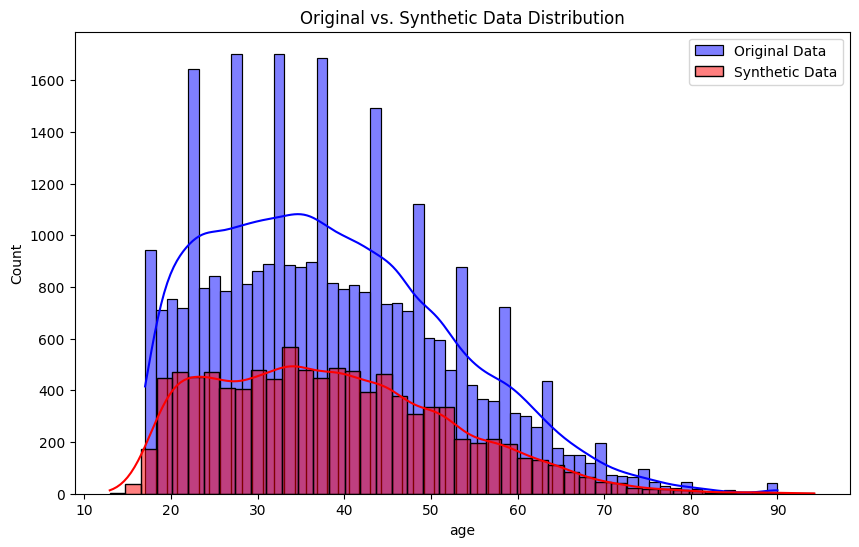

In [649]:
#10000 datapoints
plt.figure(figsize=(10, 6))
sns.histplot(age_hours_df['age'], kde=True, color='blue', label='Original Data', alpha=0.5)
sns.histplot(synthetic_df['age'], kde=True, color='red', label='Synthetic Data', alpha=0.5)
plt.legend()
plt.title("Original vs. Synthetic Data Distribution")
plt.show()

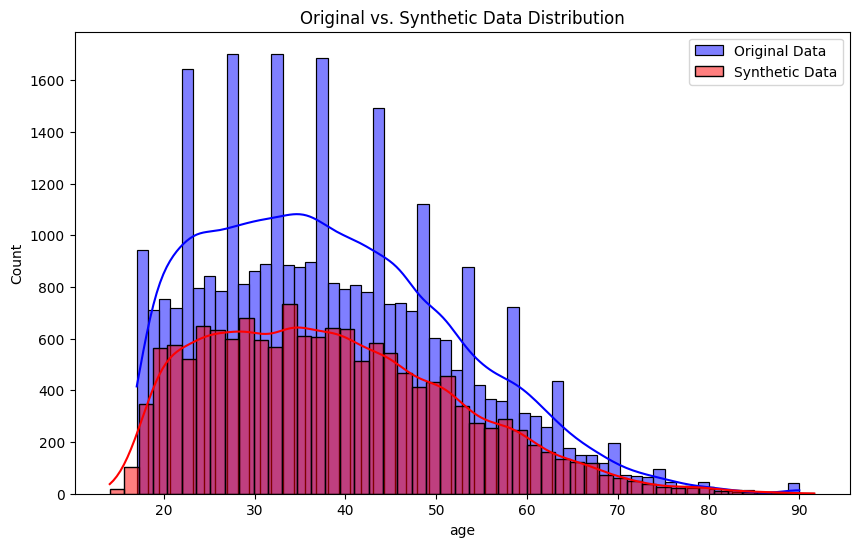

In [650]:
#15000
plt.figure(figsize=(10, 6))
sns.histplot(age_hours_df['age'], kde=True, color='blue', label='Original Data', alpha=0.5)
sns.histplot(synthetic_df1['age'], kde=True, color='red', label='Synthetic Data', alpha=0.5)
plt.legend()
plt.title("Original vs. Synthetic Data Distribution")
plt.show()

 21%|██        | 6871/32561 [20:46<1:17:39,  5.51it/s]


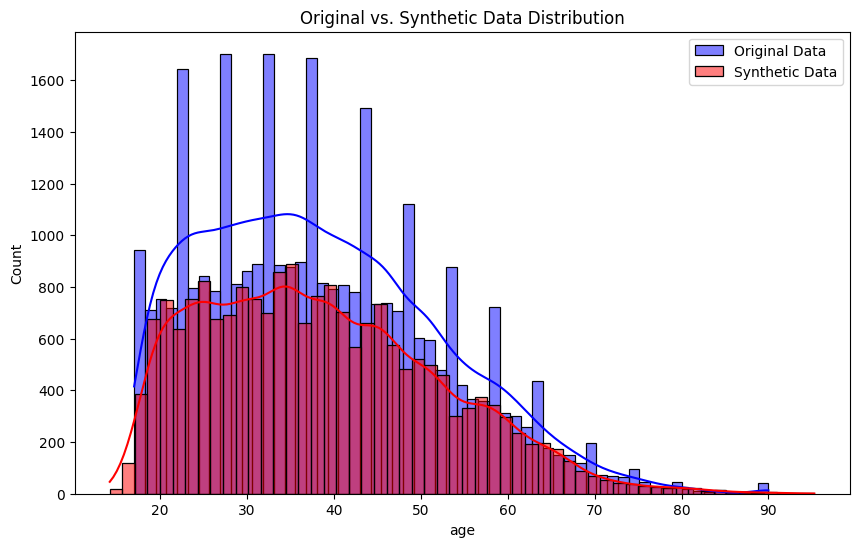

In [651]:
#20000
plt.figure(figsize=(10, 6))
sns.histplot(age_hours_df['age'], kde=True, color='blue', label='Original Data', alpha=0.5)
sns.histplot(synthetic_df2['age'], kde=True, color='red', label='Synthetic Data', alpha=0.5)
plt.legend()
plt.title("Original vs. Synthetic Data Distribution")
plt.show()

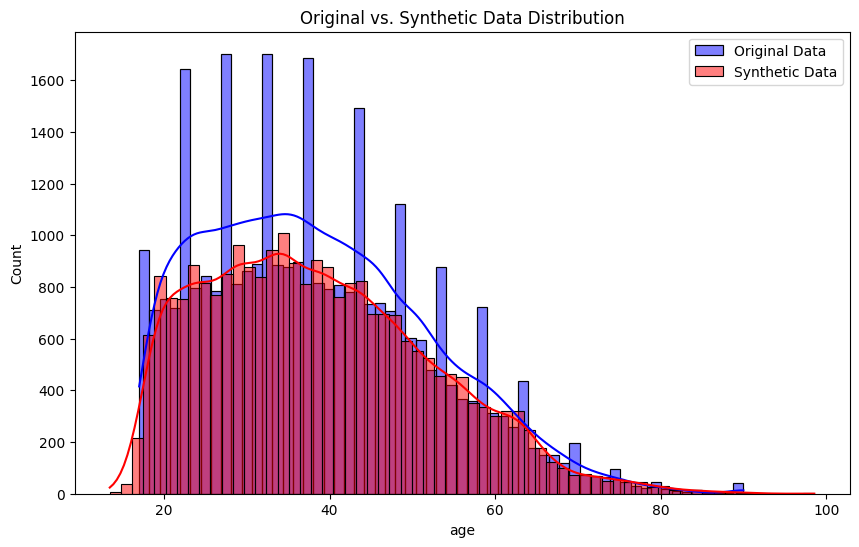

In [652]:
#25000
plt.figure(figsize=(10, 6))
sns.histplot(age_hours_df['age'], kde=True, color='blue', label='Original Data', alpha=0.5)
sns.histplot(synthetic_df3['age'], kde=True, color='red', label='Synthetic Data', alpha=0.5)
plt.legend()
plt.title("Original vs. Synthetic Data Distribution")
plt.show()

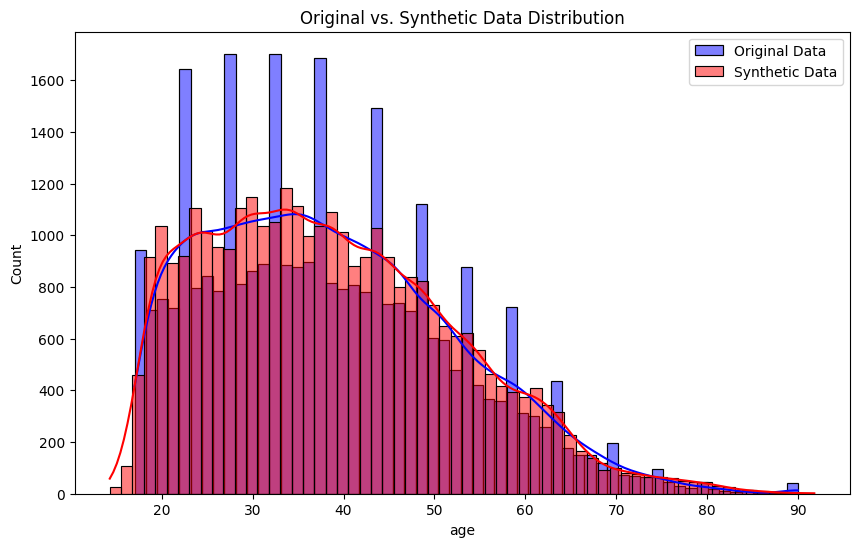

In [653]:
# full size data

plt.figure(figsize=(10, 6))
sns.histplot(age_hours_df['age'], kde=True, color='blue', label='Original Data', alpha=0.5)
sns.histplot(synthetic_df_full['age'], kde=True, color='red', label='Synthetic Data', alpha=0.5)
plt.legend()
plt.title("Original vs. Synthetic Data Distribution")
plt.show()

## Conduct the evalution on the GMM synthesized data


In [644]:
metadata1 = SingleTableMetadata()
metadata1.detect_from_dataframe(data = age_hours_df)
baseline_quality_report = evaluate_quality(
    age_hours_df,  #real data
    synthetic_df_full, #synthetic data(perfect synthesizer generated(holdout))
    metadata1
)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 1/1 [00:00<00:00, 62.54it/s]

Overall Quality Score: 92.39%

Properties:
- Column Shapes: 87.46%
- Column Pair Trends: 97.32%


In [647]:
# use sdv to generate two column data based on the gaussian copula
metadata1 = SingleTableMetadata()

metadata1.detect_from_dataframe(data = age_hours_df)
synthesier = GaussianCopulaSynthesizer(metadata1)
synthesier.fit(age_hours_df)
synthetic_data_sdv = synthesier.sample(num_rows = num_rows) ##keep the number of rows equal to the data hold
synthetic_data_sdv

,age,hours-per-week
0,40,56
1,44,47
2,39,54
3,32,43
4,26,36
...,...,...
32556,19,42
32557,32,33
32558,55,60
32559,28,54


In [648]:
#get the score
metadata1 = SingleTableMetadata()
metadata1.detect_from_dataframe(data = age_hours_df)
baseline_quality_report = evaluate_quality(
    age_hours_df,  #real data
    synthetic_data_sdv, #synthetic data(perfect synthesizer generated(holdout))
    metadata1
)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 1/1 [00:00<00:00, 108.69it/s]

Overall Quality Score: 91.75%

Properties:
- Column Shapes: 86.99%
- Column Pair Trends: 96.52%


In [654]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=age_hours_df,
    synthetic_data=synthetic_df_full,
    column_name=' hours-per-week',
    metadata=metadata1
)
    
fig.show()

In [665]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=age_hours_df,
    synthetic_data=synthetic_data_sdv,
    column_name=' hours-per-week',
    metadata=metadata1
)
    
fig.show()

In [655]:
#gmm
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=age_hours_df,
    synthetic_data=synthetic_df_full,
    column_name='age',
    metadata=metadata1
)
    
fig.show()

In [666]:
# SDV
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=age_hours_df,
    synthetic_data=synthetic_data_sdv,
    column_name='age',
    metadata=metadata1
)
    
fig.show()

In [656]:
def range_coverage(original_data, synthetic_data, column_names):
    """
    Compute the Range Coverage for multiple numerical columns.

    Parameters:
    - original_data: DataFrame containing the original data.
    - synthetic_data: DataFrame containing the synthetic data.
    - column_names: List of numerical column names to compute Range Coverage for.

    Returns:
    - Dictionary with Range Coverage scores for the specified columns.
    """
    
    coverage_results = {}
    
    for column_name in column_names:
        # Determine the support (range) of the original data
        min_r = original_data[column_name].min()
        max_r = original_data[column_name].max()

        # Determine the support (range) of the synthetic data
        min_s = synthetic_data[column_name].min()
        max_s = synthetic_data[column_name].max()

        # Calculate the components of the Range Coverage formula
        component_1 = max((min_s - min_r) / (max_r - min_r), 0)
        component_2 = max((max_r - max_s) / (max_r - min_r), 0)

        # Calculate Range Coverage score
        coverage_score = 1 - component_1 - component_2
        
        # Store the result in the dictionary
        coverage_results[column_name] = coverage_score
    
    return coverage_results

In [660]:
range_coverage_column = age_hours_df.columns[(age_hours_df.dtypes =='int64') | (age_hours_df.dtypes=='float64')].tolist()
# print(range_coverage_column)
# List of model names
model_names = ["GMM_SYN", "SYN_SDV", "ORG"]

# List of datasets corresponding to the model names
datasets = [synthetic_df_full, synthetic_data_sdv, age_hours_df]

final_result_range_coverage = {}

# Iterate over model names and datasets
for model_name, dataset in zip(model_names, datasets):
    result = range_coverage(age_hours_df, dataset, range_coverage_column)
    final_result_range_coverage[model_name] = result

final_result_range_coverage_df = pd.DataFrame(final_result_range_coverage)
avg_col = final_result_range_coverage_df.mean()
final_result_range_coverage_df= pd.concat([final_result_range_coverage_df,avg_col.to_frame().T], ignore_index=True)
final_result_range_coverage_df.index= range_coverage_column + ["Average"]
final_result_range_coverage_df.index.name = 'Range Coverage For Feature'
final_result_range_coverage_df

,GMM_SYN,SYN_SDV,ORG
Range Coverage For Feature,,,
age,1.0,1.000000,1.0
hours-per-week,1.0,0.938776,1.0
Average,1.0,0.969388,1.0
